In [1]:
import tensorflow as tf
import pandas as pd
import re
import keras
from keras import Model
from tensorflow.keras.layers import Flatten, LSTM, Dense, Embedding, SpatialDropout1D, Dropout, AveragePooling1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras_preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Open csv with political reviews
with open('/content/drive/MyDrive/test.csv', 'r', encoding='utf-8', errors='ignore') as file:
    text = file.readlines()
# create dataframe
x_train = pd.DataFrame()

In [3]:
# Fill dataframe, label = 1 means positive review, label = 0 means negative
word = []
label = []
for n in text:
    n = n.split(",")
    label.append(1) if "2" in n[0] else label.append(0)
    word.append(" ".join(n[1:]))
x_train['consumer_review'] = word
x_train['polarity_label'] = label

In [4]:
# view raw text and compare with frame
for i in range(1, 10):
  print(text[i])
  print(x_train.iloc[i])
  print()

"2","One of the best game music soundtracks - for a game I didn't really play","Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of songs in my other video game soundtracks. I must admit that one of the songs (Life-A Distant Promise) has brought tears to my eyes on many occasions.My one complaint about this soundtrack is that they use guitar fretting effects in many of the songs, which I find distracting. But even if those weren't included I would still consider the collection worth it."

consumer_review    "One of the best game music soundtracks - for ...
polarity_label                                                     1
Name: 1, dtype: object

"1","Batterie

In [5]:
# use train_test_split to use only 20% of data
drop_x, x_set, drop_y, y_set = model_selection.train_test_split(x_train['consumer_review'], x_train['polarity_label'],test_size=0.50)
print("New lenght of data set", len(y_set))

New lenght of data set 200000


In [6]:
# Clean data
def data_prep(in_text):
    # remove punctuations and numbers
    out_text = re.sub('[^a-zA-Z]', ' ', in_text)
    # convert upper case to lower case
    out_text = "".join(list(map(lambda x: x.lower(), out_text)))
    # Remove single characters
    out_text = re.sub(r"\s+[a-zA-Z]\s+", ' ', out_text)
    return out_text

In [7]:
# create new cleaned dataset
text_set = []
for reviews in list(x_set):
    text_set.append(data_prep(reviews))

# Print the cleaned dataset
print(text_set[0])
print()

 ok hair elastics   these were simply   ok probably will not repurchase again  they are no better than drug store grade silicone bands   



In [8]:
x_train = pd.DataFrame()
x_train['consumer_review'] = text_set
x_train['polarity_label'] = list(y_set)
print(x_train)

# Split data into 70% train and 30% test
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train['consumer_review'], x_train['polarity_label'], test_size=0.30)

# convert lists into arrays to tokenize data
x_train = np.array(x_train.values.tolist())
x_test = np.array(x_test.values.tolist())
y_train = np.array(y_train.values.tolist())
y_test = np.array(y_test.values.tolist())

                                          consumer_review  polarity_label
0        ok hair elastics   these were simply   ok pro...               0
1        sounds great bought this microphone to use fo...               1
2        classic disappointment   this toaster oven br...               0
3        brilliant    finally documentary that demonst...               1
4        easy to use but just fine have problem waking...               0
...                                                   ...             ...
199995   garbage   won run on windows xp  even with th...               0
199996   they seem good quality  but the size is incor...               0
199997   don wait for the movie  there won be one    t...               0
199998   great believe that when you have to replace f...               1
199999   falls far short of expectations    with all t...               0

[200000 rows x 2 columns]


In [9]:
# Tokenize data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
total_size = len(word_index)+1
print("Length of word index", total_size)

# Convert the text input to sequences for processing in the LSTM
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Add padding so that all arrays have the same size
max_length = 100
x_train = pad_sequences(x_train, padding='post', maxlen=max_length)
x_test = pad_sequences(x_test, padding='post', maxlen=max_length)

print(x_train)

Length of word index 133847
[[    5    17    12 ...  1454     3   173]
 [  711    93  1929 ...     0     0     0]
 [  425   303     5 ...     2  2824   212]
 ...
 [   45   587     5 ...     8     1  1501]
 [   32    78 22499 ...     0     0     0]
 [   13    20    31 ...     0     0     0]]


In [10]:
# Finally create and structure the model
model = Sequential()
model.add(Embedding(total_size, 64, input_length=max_length, mask_zero=True))
model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [11]:
# Compile the model, specify optimizer, loss function and metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           8566208   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          132000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                12864     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

Epoch 1/3
4375/4375 [==============================] - 4573s 1s/step - loss: 0.3398 - acc: 0.8454 - val_loss: 0.2251 - val_acc: 0.9082
Epoch 2/3
4375/4375 [==============================] - 4568s 1s/step - loss: 0.1790 - acc: 0.9333 - val_loss: 0.2553 - val_acc: 0.8977
Epoch 3/3
4375/4375 [==============================] - 4568s 1s/step - loss: 0.1219 - acc: 0.9560 - val_loss: 0.2511 - val_acc: 0.9089
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


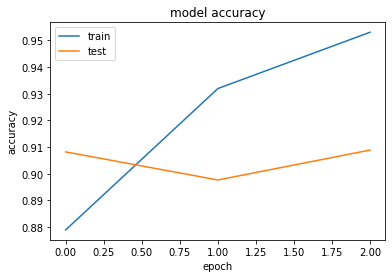

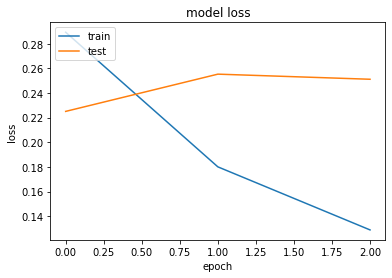

<Figure size 432x288 with 0 Axes>

In [12]:
# Train the model
hystory = model.fit(x_train, y_train, batch_size=32, epochs=3, verbose=1, validation_data=(x_test, y_test))
model.save("/content/drive/MyDrive/amazon.h5")

#List all data in history
print(hystory.history.keys())

#Plotting accuracy
plt.plot(hystory.history['acc'])
plt.plot(hystory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy_plot.png')

#Plotting loss
plt.plot(hystory.history['loss'])
plt.plot(hystory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss_plot.png')

In [13]:
test_set = ["one of the best game music soundtracks for a game I did not really play despite the fact that i have only played a small portion of the game the music i heard plus the connection to chrono trigger which was great as well led me to purchase the soundtrack and it remains one of my favorite albums there is an incredible mix of fun epic and emotional songs those sad and beautiful tracks i especially like as there is not too many of those kinds of songs in my other video game soundtracks i must admit that one of the songs life a distant promise has brought tears to my eyes on many occasions my one complaint about this soundtrack is that they use guitar fretting effects in many of the songs which i find distracting but even if those were not included i would still consider the collection worth it"]
test_set = np.array(test_set) 

# Convert the text input to sequences for processing in the LSTM
test_set = tokenizer.texts_to_sequences(test_set)

# Add padding so that all arrays have the same size
max_length = 100
test_set = pad_sequences(test_set, padding='post', maxlen=max_length)
print(test_set)

[[  2415     22      5     19    285    563     47      7     38    961
     869      5    204   2654      2   1627    153    177    689      2
     358    517    724    352     30     20     47      7     13     80
     111      5    177   2617      5    153      8     19     69    265
     139   5988    724    169   1219     10     22      5      1    153
     149    209   5607   2496     43   1075   1987      3     19    922
      16    111   4713     19     22   1277     40      6    957      7
      10     29     88    672 116468    929      8    111      5      1
     153     83    724    134   3283     14     72     26    177     81
      13    716    724     37    118    983      1    361    154      4]]


In [14]:
#Load the model
model = keras.models.load_model("/content/drive/MyDrive/amazon.h5")
# Generate predictions on political data
print("Generating predictions LSTM vs Group 2")
predictions = model.predict(test_set)
print(predictions)

Generating predictions LSTM vs Group 2
[[0.9993068]]
